In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt

from functools import partial

In [2]:
from cxai import factory
from cxai import utils as putils

from cxai import inspector

from cxai import drsa

# Introduction

This notebook provides necessary implementation to reproduce Figure 1 in our paper on "Disentangled Explanations of Neural Prediction via Relevance Subspace Analysis".

We use the pretrained VGG16 from TorchVision and build [PRCA][prca] and [DRSA][drsa] at Layer Conv4_3. We use LRP to produce explanations.

[prca]: #Principal-Relevance-Subspace-Analysis-(PRCA):-Extracting-a-Maximally-Contributing-Subspace
[drsa]: #Disentangled-Relevant-Subspace-Analysis-(DRSA):-Extracting-Subspaces-for-Disentangled-Explanations

## Variables Declaration

In [3]:
# declare variables
ARCH = "torchvision-vgg16-imagenet"
LAYER = "conv4_3"

ARCH_LAYER_SLUG = f"{ARCH}-{LAYER}"

NSID = "n02802426"
TOTAL_IMAGES = 4

NUMBER_SUBSPACES = 4

In [4]:
label = putils.imagenet.get_index_from_imagenet_id(NSID)
class_name = putils.imagenet.get_desc_from_imagenet_id(NSID)
NSID, label, class_name

('n02802426', 430, 'basketball')

In [5]:
model, (rc_transform, input_transform) = factory.make_model(ARCH)

## Data Exploration

We provide four training images of Class Basketball; these images are part of the ImageNet dataset. 

In [6]:
images = list(map(
    lambda i: putils.load_image(f"../data/images/img-{i}.jpg"),
    range(4)
))

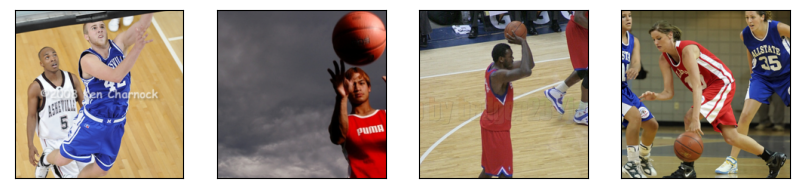

In [7]:
def ano():
    
    ncols = TOTAL_IMAGES
    
    plt.figure(figsize=(2.5*ncols, 2.5))
    
    for i in range(ncols):
        plt.subplot(1, ncols, i+1)
        putils.viz.imshow(
            rc_transform(images[i])
        )
ano()

# Standard Explanation

In [8]:
explainer = factory.make_explainer("lrp", model)

/home/pat/projects/drsa-demo/venv/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


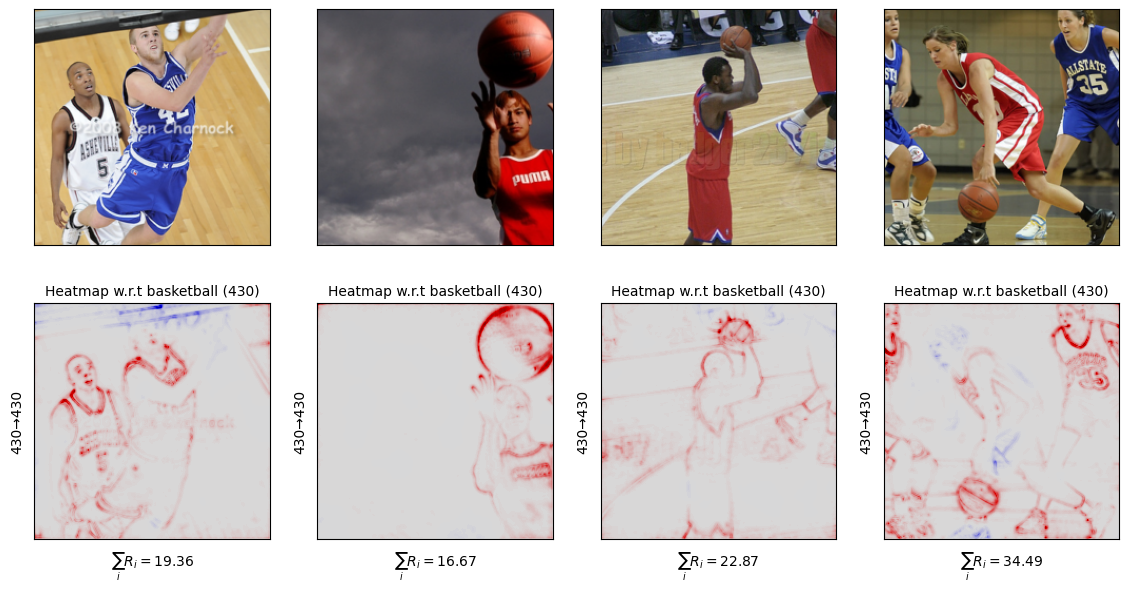

In [9]:
def ano():
    
    ncols = TOTAL_IMAGES
    nrows = 2
    
    plt.figure(figsize=(3.5*ncols, 3.5*nrows))
    
    for ix, img in enumerate(images):
        plt.subplot(nrows, ncols, ix+1)
        putils.viz.imshow(
            rc_transform(img)
        )
        
        # compute heatmap
        logits, standard_heatmap = explainer.explain(
            input_transform(img),
            label,
        )

        pred_label = np.argmax(logits)
        # sum over channels
        standard_heatmap = standard_heatmap.sum(axis=0)

        plt.subplot(nrows, ncols, ncols + ix+1)

        putils.viz.heatmap(
            standard_heatmap,
            title=f"Heatmap w.r.t {class_name} ({label})"
        )
        plt.ylabel(f"{label}→{pred_label}")
ano()

# Principal Relevance Subspace Analysis (PRCA): Extracting a Maximally Contributing Subspace

Suppose $\mathcal D = \{(\boldsymbol a \in \mathbb{R}^d,\boldsymbol c \in \mathbb{R}^d)\}$ is a collection of activation and context vectors extracted from training images of Class Basketball. The objective of PRCA is 
$$
\max_U (U^\top \boldsymbol a)^\top (U^\top \boldsymbol c),
$$
where $U \in \mathbb{R}^{d \times d'}$ and $d'$ is a chosen number of dimensions. The solution to the objective is $U$ being the first $d'$ eigenvectors of the cross-correlation matrix
$
   \Sigma_c := \mathbb{E}_{\mathcal D}[ \boldsymbol a \boldsymbol c^\top + \boldsymbol c \boldsymbol a^\top] \in \mathbb{R}^{d \times d},
$
and we can find the eigenvectors using 
$$
    U  \leftarrow \texttt{eigh}(\Sigma_c).
$$

In [10]:
def compute_prca(ss=10):    
    mat_act = np.load(f"../data/raw/{NSID}/training-samples/{ARCH_LAYER_SLUG}/act.npy")
    mat_ctx = np.load(f"../data/raw/{NSID}/training-samples/{ARCH_LAYER_SLUG}/lrp/ctx.npy")
    
    # compute cross-correlation matrix
    mat_cross_cov = (mat_act.T @ mat_ctx + mat_ctx.T @ mat_act) / mat_act.shape[0]
    
    np.testing.assert_allclose(
        mat_cross_cov,
        mat_cross_cov.T
    )
    
    _, eigvecs =  np.linalg.eigh(mat_cross_cov)
    
    # in Numpy, the order of eigenvalues is in ascending.
    # Therefore, we have to reverse the order.
    eigvecs = eigvecs[:, ::-1].copy()
    eigvecs = eigvecs[:, :ss]
    
    eigvecs = eigvecs[:, None, :]
    
    return eigvecs

In [11]:
# Our implementation expect the shape of U to be (layer dimension, number of subspaces, subspace size)
U_prca = compute_prca()
U_prca.shape

(512, 1, 10)

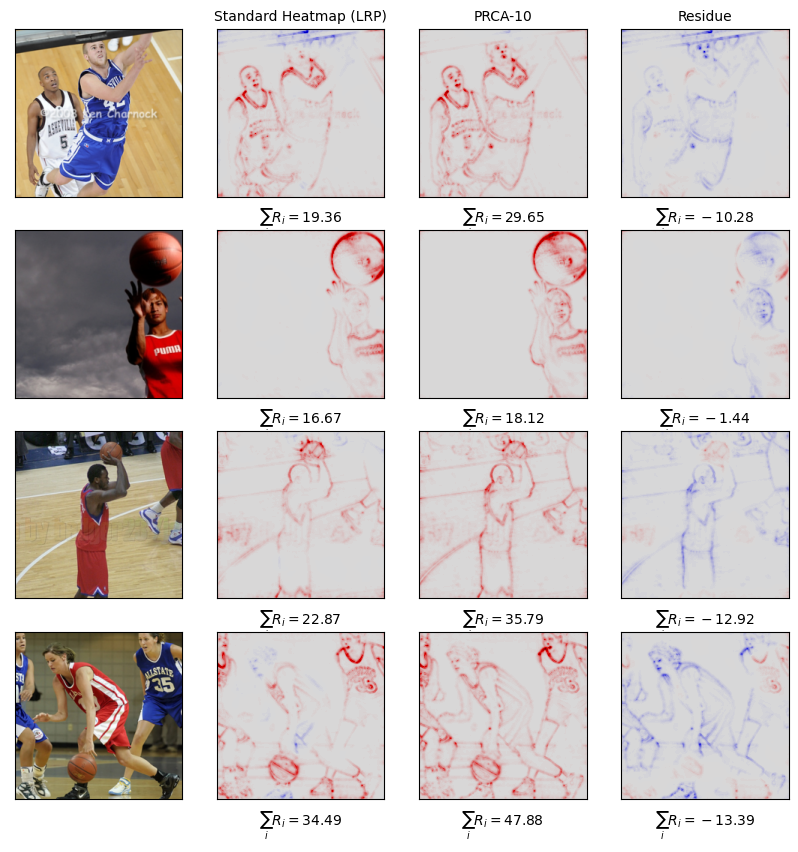

In [12]:
def ano():
    
    # The inspector handles the projections of activation and context vectors
    # on a given projection matrix. 
    # In this case, the projection matrix is learned from PRCA
    insp = inspector.GroupBasisInspector(
        layer=LAYER,
        weights=U_prca,
        verbose=False
    )
    
    
    
    ncols = 4
    nrows = len(images)
    plt.figure(figsize=(2.5*ncols, 2.5*nrows))

    
    for ix, img in enumerate(images):
        
        # produce subspace explanations with the defined inspector
        _, hm, info_prca = explainer.explain_with_inspector(
            input_transform(img),
            label,
            inspector=insp,
            # We set this to `1` because we have on only one subspace.
            top_k=1
        )

        hm = hm.sum(axis=0)

        plt.subplot(nrows, ncols, ncols*ix + 1)
        putils.viz.imshow(rc_transform(img))


        plt.subplot(nrows, ncols, ncols*ix + 2)
        putils.viz.heatmap(
            hm,
            title="Standard Heatmap (LRP)" if ix == 0 else ""
        )


        plt.subplot(nrows, ncols, ncols*ix + 3)
        putils.viz.heatmap(
            info_prca.input_top_k_source_heatmaps[0].sum(axis=0),
            title="PRCA-10" if ix == 0 else "",
            reference_heatmap=hm
        )

        plt.subplot(nrows, ncols, ncols*ix + 4)
        putils.viz.heatmap(
            info_prca.input_subspace_residue_heatmap.sum(axis=0),
            title="Residue" if ix == 0 else "",
            reference_heatmap=hm
        )
ano()

# Disentangled Relevant Subspace Analysis (DRSA): Extracting Subspaces for Disentangled Explanations

Recall $\mathcal D = \{(\boldsymbol a \in \mathbb{R}^d,\boldsymbol c \in \mathbb{R}^d)\}$ the collection of activation and context vectors. Let $i \in \{n, \cdots, |\mathcal D | \}$ and $j \in \{1, \cdots, d\}$. We define

$$
\hat{\boldsymbol{a}}= \frac{1}{\sqrt[4]{d}}\frac{\boldsymbol{a}}{ \sqrt{\mathbb{E}_{n,j} [ a_{n,j}^2 } ]}, \quad \hat{\boldsymbol{c}}= \frac{1}{\sqrt[4]{d}}\frac{\boldsymbol{c}}{ \sqrt{\mathbb{E}_{n,j} [ c_{n,j}^2 } ]}.
$$

Denote $U_k \in \mathbb{R}^{d\times d'_k}$ with $\sum_k d'_k = d$ and $\boldsymbol{U} = (U_k)_k$ to be the column-wise concatenation of $U_k$'s. We impose that $\boldsymbol U^\top \boldsymbol U=  I$. Define $\mathcal K$ to be the index set of subspaces and 
 
$$
\forall k \in \mathcal K: R_k^{(n)}(\boldsymbol{U}) = \max(0, (U_k^\top \boldsymbol a_n)^\top (U_k^\top \boldsymbol c_n)).
$$

The objective of DRSA is 

$$
\max_{\boldsymbol U} \mathbb{M}^{0.5}_{k \in \mathcal K} \mathbb{M}^{2}_{n \in \mathcal D}[ R_k^{(n)}(\boldsymbol{U})] \quad  \text{subject to:}\ \boldsymbol{U}^\top \boldsymbol{U}= I,
$$

where $\mathbb{M}^p$ denotes the generalized F-mean with function $F(t) = t^p$; that is $
\mathbb{M}^p(\{x_i\}) = \sqrt[p]{\sum_i x_i^p}
$. Specifically, one can interpret $\mathbb{M}^2$ and $\mathbb{M}^{0.5}$ as soft max- and min-pooling respectively. 


With this setup, we find $\boldsymbol{U}$ by an iterative procedure in which we alternate between  gradienta ascent on the objective and orthogonalization of the solution at the iteration. Due to non-convexity, we also select the best solution from 3 different initialization.

Once the training finises, we reorder the $|\mathcal K|$ subspaces based on the average total relevance they capture; the first subspace is the one with the highest average total relevance.

In [13]:
def compute_drsa(
    use_pretrained=True,
    device="cpu",
    num_subspaces=NUMBER_SUBSPACES,
    seed=1,
    epochs=2500
):
    if use_pretrained:
        print("Using pre-trained U_drsa")
        return np.load(f"../data/raw/{NSID}/training-samples/{ARCH_LAYER_SLUG}/lrp/bases/drsa-ns4-ss128-sm2-seed1/weights.npy")
    
    mat_act = np.load(f"../data/raw/{NSID}/training-samples/{ARCH_LAYER_SLUG}/act.npy")
    mat_ctx = np.load(f"../data/raw/{NSID}/training-samples/{ARCH_LAYER_SLUG}/lrp/ctx.npy")
    
    
    dims = mat_act.shape[1]
    
    subspace_size = dims // num_subspaces
    
    print(f"Training DRSA with {num_subspaces} {subspace_size}-dimensional subspaces (d={dims}, seed={seed})")

    # We do this normalization because activation and context vectors
    # from different layers are likely to have different magnitudes.
    # This normalization therefore stabilize the training.
    mat_act = mat_act / ((np.mean(mat_act**2) ** (1 / 2)) * (dims ** (1 / 4)))
    mat_ctx = mat_ctx / ((np.mean(mat_ctx**2) ** (1 / 2)) * (dims ** (1 / 4)))
    
    mat_act = torch.from_numpy(mat_act).to(device)
    mat_ctx = torch.from_numpy(mat_ctx).to(device)
    
    
    obj_fun = partial(drsa.obj_drsa, softmin_ord=2)

    (
        best_obj,
        U_drsa,
        best_obj_values,
    ) = drsa.train_model_with_inner_model_selection(
        obj_func=obj_fun,
        act=mat_act,
        ctx=mat_ctx,
        seed=seed,
        ns=num_subspaces,
        ss=subspace_size,
        epochs=epochs,
        device=device,
    )
    
    
    # Reorder learned subspaces
    U_drsa = U_drsa.reshape((dims, num_subspaces, subspace_size))
        
    relevence_on_U = (
        torch.einsum("nd,dij->nij", mat_act,U_drsa) * torch.einsum("nd,dij->nij", mat_act, U_drsa)
    )
    relevence_on_U = relevence_on_U.sum(axis=2)  
    mean_relevence_on_U = relevence_on_U.mean(axis=0)
    
    sorted_indices = torch.argsort(-mean_relevence_on_U)
    
    U_drsa = U_drsa.cpu().numpy()
    U_drsa = U_drsa[:, sorted_indices, :].copy()
    
    return U_drsa

In [14]:
#  Remark: Training on a CPU (Intel(R) i7@2.80GHz) takes approximately 4 minutes per trial.
U_drsa = compute_drsa(use_pretrained=True)
U_drsa.shape

Using pre-trained U_drsa


(512, 4, 128)

In [ ]:
def ano():
    nrows = TOTAL_IMAGES
    ncols = 3 + NUMBER_SUBSPACES
    
    size = 2.5
    
    plt.figure(figsize=(size*ncols, size*nrows))
    
    
    for ix, img in enumerate(images):
        
        _, standard_heatmap, inspection_info = explainer.explain_with_inspector(
            input_transform(img),
            label,
            inspector=inspector.GroupBasisInspector(
                layer=LAYER,
                weights=U_drsa
            ),
            top_k=4
        )

        canonical_order = np.argsort(inspection_info.top_k_sources)
        subspace_heatmaps = inspection_info.input_top_k_source_heatmaps[canonical_order, :, :, :]

        # sum over channels
        subspace_heatmaps = subspace_heatmaps.sum(axis=1)
        standard_heatmap = standard_heatmap.sum(axis=0)

        plt.subplot(nrows, ncols, ix*ncols + 1)
        putils.viz.imshow(rc_transform(img))
        
        plt.subplot(nrows, ncols, ix*ncols + 2)
        putils.viz.heatmap(
            standard_heatmap,
            title=f"Standard Heatmap (LRP)" if ix == 0 else "",
        )
        
        # visualization
        for six in range(NUMBER_SUBSPACES):
            plt.subplot(nrows, ncols, ix*ncols + 3 + six)

            putils.viz.heatmap(
                subspace_heatmaps[six],
                title=f"DRSA Subspace {six+1}" if ix == 0 else "",
                reference_heatmap=standard_heatmap
            )
    plt.tight_layout()
ano()